<a href="https://colab.research.google.com/github/CarlosSandoval-03/MetNumUN2024II/blob/main/LAB%20ATQ/strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

# Ejecutar en Local

In [ ]:
!pip install git+https://github.com/quantiacs/toolbox.git 2>/dev/null

  Cloning https://github.com/quantiacs/toolbox.git to /tmp/pip-req-build-itv3w3lp
  Resolved https://github.com/quantiacs/toolbox.git to commit a1e6351446cd936532af185fb519ef92f5b1ac6d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 12.7 MB/s eta 0:00:00
  Created wheel for qnt: filename=qnt-0.0.409-py3-none-any.whl size=115541 sha256=d171846a66edfd4925f35004fb9b69f380f77b8c1f1e400c08489f7e68c4c56d
  Stored in directory: /tmp/pip-ephem-wheel-cache-5dwok9bm/wheels/ca/03/48/1dbd01eee19642348a025488a55e2290c63d6b83473b2b8b9a
Successfully built qnt
  Attempt

In [ ]:
import os
os.environ['API_KEY'] = '93c84877-8a46-40f2-9c37-d67eb167f74b'
os.environ['NONINTERACT'] = 'True'

# Codigo Quantiacs

In [ ]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.output as qnout    # Manejar la salida de resultados.
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

NOTICE: The environment variable DATA_BASE_URL was not specified. The default value is 'https://data-api.quantiacs.io/'
NOTICE: The environment variable CACHE_RETENTION was not specified. The default value is '7'
NOTICE: The environment variable CACHE_DIR was not specified. The default value is 'data-cache'


# CALIFICACION: The market and assets

Change the market from NASDAQ to S&P 500 and include a minimum of 20 assets, in a comment explaining your choice.

## RTA
En este caso se toman todos los assets disponibles en el S&P. Esto debido a que se busca un algoritmo que pueda facilmente ser aplicado al mundo real y permita maximizar las ganancias aprovechando la totalidad del mercado.

In [ ]:
# loading nasdaq-100 stock data
stocks_list = qndata.stocks.load_spx_list(min_date='2006-01-01')

stock_data = qndata.stocks.load_spx_data(min_date="2006-01-01", assets=stocks_list)

close = stock_data.sel(field="close").to_dataframe()
print(close.head())
print(close.columns)

| | #                                             | 15975 Elapsed Time: 0:00:00
| | #                                             | 15975 Elapsed Time: 0:00:00
| |              #                              | 3337716 Elapsed Time: 0:00:01


fetched chunk 1/12 7s


| |              #                              | 3401044 Elapsed Time: 0:00:01


fetched chunk 2/12 11s


| |              #                              | 3297805 Elapsed Time: 0:00:01


fetched chunk 3/12 15s


| |              #                              | 3139607 Elapsed Time: 0:00:01


fetched chunk 4/12 20s


| |              #                              | 3419284 Elapsed Time: 0:00:01


fetched chunk 5/12 23s


| |              #                              | 3478527 Elapsed Time: 0:00:01


fetched chunk 6/12 26s


| |              #                              | 3403299 Elapsed Time: 0:00:01


fetched chunk 7/12 29s


| |              #                              | 3511409 Elapsed Time: 0:00:01


fetched chunk 8/12 33s


| |             #                               | 3456440 Elapsed Time: 0:00:01


fetched chunk 9/12 36s


| |              #                              | 3538852 Elapsed Time: 0:00:01


fetched chunk 10/12 39s


| |              #                              | 3771403 Elapsed Time: 0:00:01


fetched chunk 11/12 42s


| |              #                              | 3566198 Elapsed Time: 0:00:01


fetched chunk 12/12 45s
Data loaded 46s
                     field  stocks_s&p500
time       asset                         
2006-01-03 NAS:AAL   close            NaN
           NAS:AAPL  close         2.6696
           NAS:ABNB  close            NaN
           NAS:ACGL  close         6.1200
           NAS:ADBE  close        38.5200
Index(['field', 'stocks_s&p500'], dtype='object')


# CALIFICACION: The variables:

Include new variables which information that you believe could improve the price prediction, in a comment explain your choice.

## RTA

Las características incluyen:
    
    * Trend indicator: Captura la dirección del mercado normalizada por volatilidad
    * MACD: Identifica cambios en la tendencia y momentum
    * Volatility measure: Mide la dispersión de precios
    * Stochastic oscillator: Identifica condiciones de sobrecompra/sobreventa
    * RSI: Mide la fuerza relativa del mercado
    * Normalized price: Precio estandarizado para comparabilidad
    * Bollinger Bands (%B): Posición relativa del precio respecto a la volatilidad
    * ATR: True Range promedio normalizado
    * Momentum: Cambio relativo de precios
    * Relative returns: Retornos porcentuales

**Su justificacion esta en los comentarios del codigo.**

In [ ]:
def get_features(data):
    """Builds the features used for learning with corrected lookback periods and proper normalization.

    Las características incluyen:
    * Trend indicator: Captura la dirección del mercado normalizada por volatilidad
    * MACD: Identifica cambios en la tendencia y momentum
    * Volatility measure: Mide la dispersión de precios
    * Stochastic oscillator: Identifica condiciones de sobrecompra/sobreventa
    * RSI: Mide la fuerza relativa del mercado
    * Normalized price: Precio estandarizado para comparabilidad
    * Bollinger Bands (%B): Posición relativa del precio respecto a la volatilidad
    * ATR: True Range promedio normalizado
    * Momentum: Cambio relativo de precios
    * Relative returns: Retornos porcentuales
    """

    # Trend (normalizado por volatilidad)
    # Justificación: La normalización por volatilidad permite comparar la fuerza de la tendencia
    # entre diferentes activos y períodos de tiempo
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 20), -1)
    trend = trend / qnta.std(data.sel(field="close"), 20)

    # MACD (normalizado)
    # Justificación: La normalización por precio permite comparar el MACD
    # entre activos de diferentes precios
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)
    macd_norm = macd2_signal.sel(field="close") / data.sel(field="close")

    # Volatilidad
    # Justificación: True Range normalizado por precio proporciona una medida
    # de volatilidad comparable entre activos
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 20)

    # Stochastic oscillator (ya normalizado)
    # Justificación: Útil para identificar reversiones potenciales en rangos de trading
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)

    # RSI (ya normalizado)
    # Justificación: Ventana de 20 períodos para alinearse con otros indicadores
    # y mantener consistencia en el análisis
    rsi = qnta.rsi(data.sel(field="close"), 20)

    # Precio normalizado
    # Justificación: La normalización (z-score) permite comparar precios
    # entre diferentes activos y períodos de tiempo
    price = data.sel(field="close").ffill("time")  # Solo forward fill para evitar look-ahead bias
    price = (price - price.rolling(time=20).mean()) / price.rolling(time=20).std()

    # Bollinger Bands (convertidas a %B indicador)
    # Justificación: %B es más útil que las bandas individuales porque:
    # 1. Normaliza el precio entre 0 y 1 respecto a las bandas
    # 2. Facilita la identificación de extremos
    # 3. Más fácil de interpretar por el modelo
    rolling_mean = data.sel(field="close").rolling(time=20).mean()
    rolling_std = data.sel(field="close").rolling(time=20).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    percent_b = (data.sel(field="close") - lower_band) / (upper_band - lower_band)

    # ATR normalizado
    # Justificación: La normalización por precio permite:
    # 1. Comparar volatilidad entre activos
    # 2. Usar el indicador como filtro de volatilidad
    # 3. Ajustar posiciones basadas en riesgo
    atr = qnta.atr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), ma=20)
    if atr is not None and isinstance(atr, xr.DataArray):
        atr = atr / data.sel(field="close")
        atr = atr.assign_coords(field="atr")

    # Momentum normalizado
    # Justificación: Usar retornos relativos en lugar de diferencias absolutas porque:
    # 1. Son comparables entre activos
    # 2. No dependen de la escala del precio
    # 3. Tienen propiedades estadísticas más deseables
    momentum = (data.sel(field="close") - data.sel(field="close").shift(time=-20)) / data.sel(field="close").shift(time=-20)

    # Retornos relativos (en lugar de diferencias de precio)
    # Justificación: Los retornos relativos son mejores que las diferencias absolutas porque:
    # 1. Son estacionarios
    # 2. Son comparables entre activos
    # 3. Tienen una interpretación porcentual clara
    returns = (data.sel(field="close") - data.sel(field="close").shift(time=-5)) / data.sel(field="close").shift(time=-5)

    # Combinación de características
    # Nota: Todas las características están normalizadas o son porcentajes,
    # lo que facilita el aprendizaje del modelo
    features = [
        (trend, "trend"),
        (macd_norm, "macd"),
        (volatility, "volatility"),
        (d, "stochastic_d"),
        (rsi, "rsi"),
        (price, "price"),
        (percent_b, "percent_b"),
        (atr, "atr"),
        (momentum, "momentum"),
        (returns, "returns")
    ]

    # Validación de características
    valid_features = []
    for feature, name in features:
        if feature is not None and feature.size > 0:
            valid_features.append(feature)
        else:
            print(f"Feature '{name}' is None or has size 0: {feature}")

    if not valid_features:
        raise ValueError("No valid features to concatenate.")

    result = xr.concat(
        valid_features,
        dim=pd.Index(
            [name for feature, name in features if feature is not None and feature.size > 0],
            name="field"
        )
    )
    return result.transpose("time", "field", "asset")

In [ ]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAL,NAS:AAPL,NAS:ABNB,NAS:ACGL,NAS:ADBE,NAS:ADI,NAS:ADP,NAS:ADSK,NAS:AEP,NAS:AKAM,...,NYS:WMB,NYS:WMT,NYS:WRB,NYS:WST,NYS:WY,NYS:XOM,NYS:XYL,NYS:YUM,NYS:ZBH,NYS:ZTS
time,,,,,,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28,0.341505,-0.010479,-0.029193,-0.049959,-0.020257,0.065838,-0.060047,-0.049981,-0.092686,-0.199604,...,0.122327,-0.255444,-0.040605,-0.013649,-0.434063,0.008772,-0.095406,-0.010974,-0.109402,-0.086772
2025-01-29,0.760070,-0.007174,-0.005874,-0.088621,-0.029114,0.035979,-0.075610,-0.074783,-0.083162,-0.210559,...,0.027661,-0.260710,-0.144208,-0.031076,-0.508286,-0.029805,-0.102486,-0.053945,-0.088391,-0.125812
2025-01-30,0.677219,-0.003515,0.013627,0.004503,-0.013193,0.040721,-0.061791,-0.069796,-0.084660,-0.141155,...,0.142334,-0.196415,-0.061843,-0.017801,-0.358608,0.126213,-0.155533,-0.054568,-0.050561,-0.075712


# CALIFICACION: The targets (Long & Short)

class_positive = 1 # prices goes up

class_negative = 0 # price goes down

for

class_positive = 1 # prices goes up more than 0.1%

class_neutral = 0 # prices goes up or don las that 0.1%

class_negative = -1 # price goes down more than 0.1%

## RTA

In [ ]:
def get_target_classes(data):
    """
    Target classes for predicting if price goes up or down based on daily return and future return.
    Returns:
        - 1 if the future return is greater than 5%
        - 0 if the future return changes by less than 5%
        - -1 if the future return is less than -5%
    """

    percentage_threshold = 0.005  # 5% threshold

    # Calculamos el retorno actual
    return_current = qnta.change(data.sel(field="close")) / data.sel(field="close")

    # Calculamos el retorno futuro (siguiente período)
    return_future = return_current.shift(time=-1)

    # Clasificación basada en umbrales
    target_classes = xr.where(return_future < -percentage_threshold, -1,
                    xr.where(return_future > percentage_threshold, 1, 0))

    return target_classes

In [ ]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data).astype(int)
display(my_targetclass.to_pandas())

asset,NAS:AAL,NAS:AAPL,NAS:ABNB,NAS:ACGL,NAS:ADBE,NAS:ADI,NAS:ADP,NAS:ADSK,NAS:AEP,NAS:AKAM,...,NYS:WMB,NYS:WMT,NYS:WRB,NYS:WST,NYS:WY,NYS:XOM,NYS:XYL,NYS:YUM,NYS:ZBH,NYS:ZTS
time,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0,0,0,1,0,1,0,-1,0,1,...,1,0,1,-1,1,0,0,1,1,0
2006-01-04,0,-1,0,-1,-1,1,-1,-1,-1,1,...,-1,-1,0,0,-1,0,0,1,-1,0
2006-01-05,0,1,0,1,1,0,1,1,1,1,...,0,0,1,0,0,1,0,0,-1,0
2006-01-06,0,0,0,-1,-1,1,0,-1,-1,-1,...,1,0,1,1,0,0,0,1,1,0
2006-01-09,0,1,0,1,1,0,-1,-1,0,1,...,1,0,0,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28,1,0,1,-1,0,0,1,-1,-1,0,...,0,0,-1,-1,-1,1,0,0,-1,0
2025-01-29,-1,-1,-1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,0,1,0,1
2025-01-30,0,-1,0,-1,-1,0,0,0,0,-1,...,-1,0,-1,-1,-1,-1,1,0,-1,-1


# CALIFICACION: The Machine Learning technique

Change linear model (linear regression) for another ML technique that you believe could improve the price prediction, in a comment explain your choice.

## RTA
El RandomForestRegressor es usado debido a:

1. Manejo de No Linealidad:
- Ideal para las interacciones complejas entre nuestros indicadores como RSI, MACD y Bollinger Bands.
- Puede capturar patrones entre momentum y volatilidad que modelos lineales ignorarían.
- Especialmente útil para detectar puntos de inflexión usando la combinación de %B y Stochastics.

2. Robustez al Ruido:
- Los indicadores técnicos generan señales ruidosas, especialmente ATR y volatilidad.
- El ensemble reduce falsas señales en los osciladores como RSI y Stochastics.
- El bagging ayuda a filtrar movimientos aleatorios en los precios.

3. Feature Importance:
- Identifica qué indicadores técnicos son más relevantes.
- Ayuda a balancear entre indicadores de tendencia (MACD) y momentum.

4. Interpretabilidad:
- Podemos entender qué indicadores técnicos influyen en cada decisión
- Facilita el ajuste de la estrategia basado en el peso de cada feature
- Permite validar si las señales tienen sentido financiero

In [ ]:
def get_model():
    """This is a constructor for the ML model (Bayesian Ridge) which can be easily
       modified for using different models.
    """
    model = RandomForestRegressor(n_estimators=10, random_state=12)
    #model = linear_model.BayesianRidge()
    return model

In [ ]:
# Create and train the models working on an asset-by-asset basis.
# Create and train models on an asset-by-asset basis.
asset_name_all = stock_data.coords["asset"].values

models = dict()

total_assets = len(asset_name_all)  # Count the total number of assets

for idx, asset_name in enumerate(asset_name_all):
    print(f"Training model {idx + 1} of {total_assets}: {asset_name}")

    # Drop missing values:
    target_cur = my_targetclass.sel(asset=asset_name).dropna("time", how="any")
    features_cur = my_features.sel(asset=asset_name).dropna("time", how="any")

    # Align features and targets:
    target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

    if len(features_cur.time) < 10:
        # Not enough points for training
        print(f"Not enough data for asset: {asset_name}. Skipping...")
        continue

    model = get_model()

    try:
        model.fit(feature_for_learn_df.values, target_for_learn_df)
        models[asset_name] = model
        print(f"Model trained for asset: {asset_name}")
    except Exception as e:
        logging.exception("Model training failed for asset: %s", asset_name)

print("Training completed for all models.")

Training model 1 of 516: NAS:AAL
Model trained for asset: NAS:AAL
Training model 2 of 516: NAS:AAPL
Model trained for asset: NAS:AAPL
Training model 3 of 516: NAS:ABNB
Model trained for asset: NAS:ABNB
Training model 4 of 516: NAS:ACGL
Model trained for asset: NAS:ACGL
Training model 5 of 516: NAS:ADBE
Model trained for asset: NAS:ADBE
Training model 6 of 516: NAS:ADI
Model trained for asset: NAS:ADI
Training model 7 of 516: NAS:ADP
Model trained for asset: NAS:ADP
Training model 8 of 516: NAS:ADSK
Model trained for asset: NAS:ADSK
Training model 9 of 516: NAS:AEP
Model trained for asset: NAS:AEP
Training model 10 of 516: NAS:AKAM
Model trained for asset: NAS:AKAM
Training model 11 of 516: NAS:ALGN
Model trained for asset: NAS:ALGN
Training model 12 of 516: NAS:AMAT
Model trained for asset: NAS:AMAT
Training model 13 of 516: NAS:AMD
Model trained for asset: NAS:AMD
Training model 14 of 516: NAS:AMGN
Model trained for asset: NAS:AMGN
Training model 15 of 516: NAS:AMZN
Model trained for 

Feature: 0, Score: 0.25050
Feature: 1, Score: 0.05860
Feature: 2, Score: 0.05148
Feature: 3, Score: 0.08347
Feature: 4, Score: 0.05895
Feature: 5, Score: 0.09505
Feature: 6, Score: 0.10769
Feature: 7, Score: 0.05753
Feature: 8, Score: 0.06202
Feature: 9, Score: 0.17469


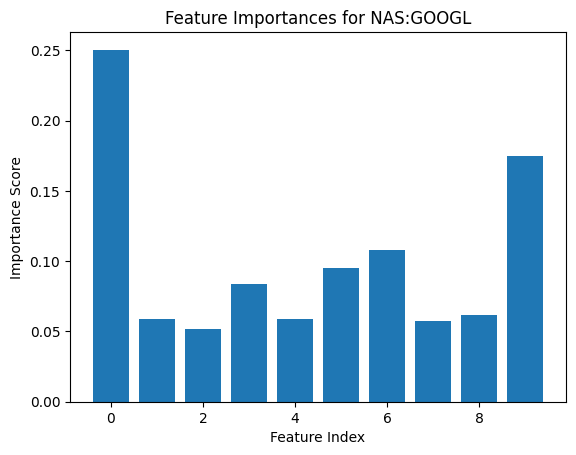

In [ ]:
# Showing which features are more important in predicting:
selected_string = 'NAS:GOOGL'
model = models[selected_string]

# Get feature importances
importance = model.feature_importances_

# Regresion lineal
#importance = models["NAS:GOOGL"].coef_

importance

# Print feature importances
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))

# Plotting the feature importances
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title(f'Feature Importances for {selected_string}')
plt.show()

In [ ]:
# Performs prediction and generates output weights:
asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="close"))

total_assets = len(asset_name_all)  # Count the total number of assets

for idx, asset_name in enumerate(asset_name_all):
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")  # Use how as a keyword argument

        if len(features_cur.time) < 1:
            print(f"No features available for asset: {asset_name}. Skipping...")
            continue

        print(f"Making predictions for model {idx + 1} of {total_assets}: {asset_name}")

        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except Exception as e:
            logging.exception("Model prediction failed for asset: %s", asset_name)

print("Predictions completed for all models.")
print(weights)

Making predictions for model 1 of 516: NAS:AAL
Making predictions for model 2 of 516: NAS:AAPL
Making predictions for model 3 of 516: NAS:ABNB
Making predictions for model 4 of 516: NAS:ACGL
Making predictions for model 5 of 516: NAS:ADBE
Making predictions for model 6 of 516: NAS:ADI
Making predictions for model 7 of 516: NAS:ADP
Making predictions for model 8 of 516: NAS:ADSK
Making predictions for model 9 of 516: NAS:AEP
Making predictions for model 10 of 516: NAS:AKAM
Making predictions for model 11 of 516: NAS:ALGN
Making predictions for model 12 of 516: NAS:AMAT
Making predictions for model 13 of 516: NAS:AMD
Making predictions for model 14 of 516: NAS:AMGN
Making predictions for model 15 of 516: NAS:AMZN
Making predictions for model 16 of 516: NAS:ANSS
Making predictions for model 17 of 516: NAS:APA
Making predictions for model 18 of 516: NAS:AVGO
Making predictions for model 19 of 516: NAS:AXON
Making predictions for model 20 of 516: NAS:BIIB
Making predictions for model 21 of 

In [ ]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

125.27263753523059

# CALIFICACION: Liquid assets
Only trade liquid assets

## RTA

In [ ]:
# Filtrar por liquidez.
is_liquid = stock_data.sel(field="is_liquid")  # Seleccionar datos de liquidez.
weights = weights * is_liquid  # Aplicar filtro de liquidez.
weights = qnout.clean(weights, stock_data, "stocks_s&p500")  # Limpiar pesos

Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [ ]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-28,5.089915e+23,0.0,0.132829,0.0,-0.125936,124.853060,16.584139,0.0,515.0,1.272855,1.54389
2025-01-29,5.089915e+23,0.0,0.132841,0.0,-0.125936,124.762549,16.573637,0.0,515.0,1.272590,1.54389
2025-01-30,5.089915e+23,0.0,0.132854,0.0,-0.125936,124.672151,16.563146,0.0,515.0,1.272324,1.54389
2025-01-31,5.089915e+23,0.0,0.132866,0.0,-0.125936,124.581865,16.552665,0.0,515.0,1.272059,1.54389
2025-02-03,5.089915e+23,0.0,0.132878,0.0,-0.125936,124.491692,16.542195,0.0,515.0,1.271795,1.54389


time,2025-02-03
field,
sharpe_ratio,124.491692


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'



Ok. This strategy does not correlate with other strategies.


In [ ]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

0.0038289526313897925

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.00547253997723005

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.6357791252123336

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [ ]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for idx, asset_name in enumerate(asset_name_all):
        #print(f"Training model {idx + 1} of {len(asset_name_all)}: {asset_name}")

        # Drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", how="any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")

        # Align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            #print(f"Not enough data to train the model for asset: {asset_name}. Skipping...")
            continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model
            #print(f"Model trained successfully for asset: {asset_name}")

        except Exception as e:
            logging.exception("Model training failed for asset: %s", asset_name)

    return models

In [ ]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for idx, asset_name in enumerate(asset_name_all):
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")

            if len(features_cur.time) < 1:
                #print(f"No features available for asset: {asset_name}. Skipping...")
                continue

            #print(f"Making predictions for asset {idx + 1} of {len(asset_name_all)}: {asset_name}")

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except Exception as e:
                logging.exception("Model prediction failed for asset: %s", asset_name)

    print("Predictions completed for all models.")
    return weights

In [ ]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...


| | #                                              | 9060 Elapsed Time: 0:00:00
| |             #                               | 2297642 Elapsed Time: 0:00:01


fetched chunk 1/1 8s
Data loaded 9s
Predictions completed for all models.


| |      #                                       | 170006 Elapsed Time: 0:00:00


fetched chunk 1/1 4s
Data loaded 4s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Run First Iteration...


| | #                                              | 9060 Elapsed Time: 0:00:00
| |            #                                | 2173248 Elapsed Time: 0:00:01


fetched chunk 1/1 5s
Data loaded 6s
Predictions completed for all models.
---
Run all iterations...
Load data...


| | #                                              | 9060 Elapsed Time: 0:00:00
| |             #                               | 2768881 Elapsed Time: 0:00:01


fetched chunk 1/8 3s


| |             #                               | 2784049 Elapsed Time: 0:00:01


fetched chunk 2/8 6s


| |             #                               | 2589246 Elapsed Time: 0:00:01


fetched chunk 3/8 9s


| |             #                               | 3066345 Elapsed Time: 0:00:01


fetched chunk 4/8 12s


| |             #                               | 3185192 Elapsed Time: 0:00:01


fetched chunk 5/8 15s


| |              #                              | 3393269 Elapsed Time: 0:00:01


fetched chunk 6/8 17s


| |             #                               | 3557838 Elapsed Time: 0:00:01


fetched chunk 7/8 21s


| |             #                               | 3181618 Elapsed Time: 0:00:01


fetched chunk 8/8 24s
Data loaded 25s


| | #                                              | 9060 Elapsed Time: 0:00:00
| |             #                               | 2803883 Elapsed Time: 0:00:01


fetched chunk 1/7 3s


| |             #                               | 2928198 Elapsed Time: 0:00:01


fetched chunk 2/7 6s


| |              #                              | 2882457 Elapsed Time: 0:00:01


fetched chunk 3/7 9s


| |             #                               | 3059293 Elapsed Time: 0:00:01


fetched chunk 4/7 12s


| |             #                               | 3349940 Elapsed Time: 0:00:01


fetched chunk 5/7 15s


| |             #                               | 3496034 Elapsed Time: 0:00:01


fetched chunk 6/7 18s


| |             #                               | 3208329 Elapsed Time: 0:00:01


fetched chunk 7/7 21s
Data loaded 22s
Backtest...


  0% (0 of 5054) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Predictions completed for all models.


 99% (5030 of 5054) |################### | Elapsed Time: 0:03:01 ETA:   0:00:00

Predictions completed for all models.


 99% (5053 of 5054) |################### | Elapsed Time: 0:05:49 ETA:   0:00:07

Predictions completed for all models.


| | #                                              | 9060 Elapsed Time: 0:00:00
| |             #                               | 2819018 Elapsed Time: 0:00:01


fetched chunk 1/7 3s


| |             #                               | 2948847 Elapsed Time: 0:00:01


fetched chunk 2/7 6s


| |             #                               | 2899117 Elapsed Time: 0:00:01


fetched chunk 3/7 9s


| |             #                               | 3086314 Elapsed Time: 0:00:01


fetched chunk 4/7 12s


| |              #                              | 3382814 Elapsed Time: 0:00:01


fetched chunk 5/7 15s


| |              #                              | 3527356 Elapsed Time: 0:00:01


fetched chunk 6/7 19s


| |             #                               | 3235297 Elapsed Time: 0:00:01


fetched chunk 7/7 22s
Data loaded 22s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-02-03
Sharpe Ratio = 24.206027029840698
Ok.
---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Output:


asset,NAS:AAL,NAS:AAPL,NAS:ABNB,NAS:ADBE,NAS:ADCT,NAS:ADI,NAS:ADP,NAS:ADSK,NAS:AEP,NAS:AKAM
time,,,,,,,,,,
2025-01-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Stats:


field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-21,8.750112e+12,0.0,0.131852,0.0,-0.156675,26.018327,3.430567,0.0,227.0,0.803534,2.456078
2025-01-22,8.750112e+12,0.0,0.131846,0.0,-0.156675,26.009667,3.429261,0.0,227.0,0.803375,2.456078
2025-01-23,8.750112e+12,0.0,0.131839,0.0,-0.156675,26.001013,3.427955,0.0,227.0,0.803216,2.456078
2025-01-24,8.750112e+12,0.0,0.131833,0.0,-0.156675,25.992365,3.426650,0.0,227.0,0.803057,2.456078
2025-01-27,8.750112e+12,0.0,0.131827,0.0,-0.156675,25.983724,3.425346,0.0,227.0,0.802898,2.456078
2025-01-28,8.750112e+12,0.0,0.131820,0.0,-0.156675,25.975088,3.424043,0.0,227.0,0.802739,2.456078
2025-01-29,8.750112e+12,0.0,0.131814,0.0,-0.156675,25.966459,3.422740,0.0,227.0,0.802580,2.456078
2025-01-30,8.750112e+12,0.0,0.131808,0.0,-0.156675,25.957836,3.421439,0.0,227.0,0.802421,2.456078
2025-01-31,8.750112e+12,0.0,0.131801,0.0,-0.156675,25.949218,3.420138,0.0,227.0,0.802262,2.456078


---


100% (5054 of 5054) |####################| Elapsed Time: 0:06:37 Time:  0:06:37


NOTA: La siguiente celda compara los wheights retornados por el backtester, no los empleados para el entrenamiento. Por esa razon sale el aviso de: `Multiply the output by data.sel(field='is_liquid') or use qnt.output.clean
`

In [ ]:
# Validar similitud con modelos existentes
qnout.check(weights, stock_data, "stocks_s&p500")

Check liquidity...


ERROR! Strategy trades non-liquid assets.
Multiply the output by data.sel(field='is_liquid') or use qnt.output.clean


Check missed dates...
Ok.
Check the sharpe ratio...


WARNING! There are not enough points in the data for the slippage calculation.
Add 15 extra data points to the data head (load data more historical data).


Period: 2006-01-03 - 2025-02-03
Sharpe Ratio = 20.222656095420582
Ok.
Check correlation.


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'



Ok. This strategy does not correlate with other strategies.


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# Log de Error
Error while loading conda entry point: conda-libmamba-solver (libarchive.so.20: cannot open shared object file: No such file or directory)
/usr/local/lib/python3.10/site-packages/conda/base/context.py:201: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3.

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
Error while loading conda entry point: conda-libmamba-solver (libarchive.so.20: cannot open shared object file: No such file or directory)
Calculation start...

# Short Description
INFO: 2025-01-25T21:36:18Z: pass started: 18030252

FAIL: 2025-01-26T02:36:20Z: pass timeout: 18030252